## Web scrapping con la API del BCRP

En el presente documento se usará la API del Banco Central de Reserva del Perú para la importación de una o más series. Para ello, se usará la librería `request` para las consultas con el servidor

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from datetime import datetime

#Ignorar warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
def wbscr_bcrp(cantidad = None):
    
    """
    Importa una serie desde el BCRPData mediante su código y las fechas deseadas.
    Se debe aplicar la función a una variable, la cual se va a convertir en una DataFrame con la información importada.
    Es opcional determinar una cantidad de series por importar. En caso que no se defina, extraerá solo una serie.
    
    -Hecho por: Mauricio Alvarado
    mauricio.alvarado@pucp.pe
    """
    
    df = pd.DataFrame()
    
    base = "https://estadisticas.bcrp.gob.pe/estadisticas/series/api"
    
    #Si no se coloca nada, es 1
    if cantidad is None:
        cantidad = 1
    else:
        cantidad = int(cantidad)
    
    
    #Comenzaremos con el loop    
    for i in range(1, cantidad + 1):
        
        series = str(input("Brindame el código de la serie: "))
        fechaini = str(input("Bridame la fecha de inicio (yyyy-p): "))
        fechafin = str(input("Bridame la fecha de fin (yyyy-p): "))
    
        url = f"{base}/{series}/json/{fechaini}/{fechafin}/ing"
        
        # Comenzando el web-scrapping dentro del BCRP
        r = requests.get(url)

        if r.status_code == 200:
            print("Vinculación con BCRPData exitosa!")
        
        else:
            print("Revisa los datos ingresados!")
            break
    
        r = r.json()
    
        periods = r.get("periods")
    
        values_list = []
        time_list = []
            
        for value in periods:
            value = value["values"][0]
            values_list.append(float(value))

        for time in periods:
            time = time["name"]
            time_list.append(time)
            
        dic = {"time": time_list, f"values_{i}": values_list}
        dic = pd.DataFrame(dic)
                        
        #Merging to the empty DataFrame
        if df.empty is True:
            df = pd.concat([df, dic])
            print(f"Haz importado tu variable N°{i}! \n")
            
        else:
            df = pd.merge(df, dic, how="outer")
            print(f"Haz importado tu variable N°{i}! \n")
    
    df = df.set_index("time")
        
    return df

In [3]:
?wbscr_bcrp

Signature: wbscr_bcrp(cantidad=None)
Docstring:
Importa una serie desde el BCRPData mediante su código y las fechas deseadas.
Se debe aplicar la función a una variable, la cual se va a convertir en una DataFrame con la información importada.
Es opcional determinar una cantidad de series por importar. En caso que no se defina, extraerá solo una serie.

-Hecho por: Mauricio Alvarado
mauricio.alvarado@pucp.pe
File:      c:\users\user\appdata\local\temp\ipykernel_22776\4023497323.py
Type:      function


La función `wbscr_bcrp` nos permite importar, por _default_ una serie y la convierte en un _Dataframe_. En este primer caso se importará la inflación mensual anuales2001-1 -con código `PN01273PM`- desde el `2001-1` hasta el `2012-12`

In [4]:
inflac = wbscr_bcrp()

Brindame el código de la serie:  PN01273PM
Bridame la fecha de inicio (yyyy-p):  2001-1
Bridame la fecha de fin (yyyy-p):  2012-12


Vinculación con BCRPData exitosa!
Haz importado tu variable N°1! 



In [5]:
inflac.head(4)

,values_1
time,
Jan.2001,3.856948
Feb.2001,3.614293
Mar.2001,3.579926
Apr.2001,2.623670


In [6]:
inflac.index = pd.to_datetime(inflac.index, format="%b.%Y")

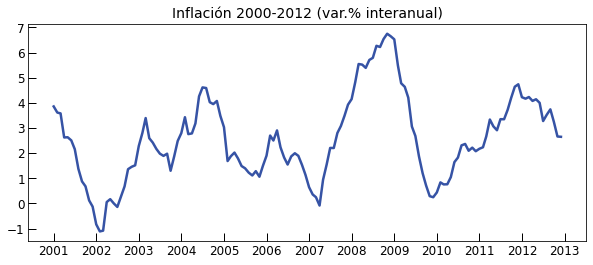

In [7]:
fig, ax = plt.subplots(figsize=(10, 4), linewidth = 2.5)

plt.title("Inflación 2000-2012 (var.% interanual)", fontsize = 14)

ax.plot(inflac, color= "#3653A5", linewidth = 2.5)

# Ticks
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(direction='in', which='both', length=8, width=1, labelsize=12) # Formato de los ticks

plt.savefig("./graphs/inflacion2000-2012.pdf", bbox_inches="tight", transparent=True)
plt.show()

De igual manera, se puede importar más de una serie. Para ello, se debe colocar la cantidad de series como parámetro en la función. Se importará el consumo privado -con código `PN02518AQ`- y el PBI trimestral con código -`PN02526AQ`-. Ambas variables trimestrales y en variaciones anuales. Los periodos serán del `2001T1`-`2019T4` 

In [8]:
dta = wbscr_bcrp(2)

Brindame el código de la serie:  PN02518AQ
Bridame la fecha de inicio (yyyy-p):  2001T1
Bridame la fecha de fin (yyyy-p):  2019T4


Vinculación con BCRPData exitosa!
Haz importado tu variable N°1! 



Brindame el código de la serie:  PN02526AQ
Bridame la fecha de inicio (yyyy-p):  2001T1
Bridame la fecha de fin (yyyy-p):  2019T4


Vinculación con BCRPData exitosa!
Haz importado tu variable N°2! 



In [9]:
dta.rename(columns = {"values_1":"consumo", "values_2":"pbi"}, inplace=True)

In [10]:
dta.tail(4)

,consumo,pbi
time,,
Q1.19,3.580000,2.436272
Q2.19,2.910332,1.169576
Q3.19,3.430878,3.363626
Q4.19,3.080000,2.006436


In [11]:
dta.index = dta.index.str[3:] + dta.index.str[:2]
dta.index = pd.PeriodIndex(dta.index.astype(str).str.replace(r'(\d{4})[0]?(\d{1})', r'\1q\2'), freq='Q').to_timestamp(freq='M')

In [12]:
dta.tail(4)

,consumo,pbi
time,,
2019-01-31,3.580000,2.436272
2019-04-30,2.910332,1.169576
2019-07-31,3.430878,3.363626
2019-10-31,3.080000,2.006436


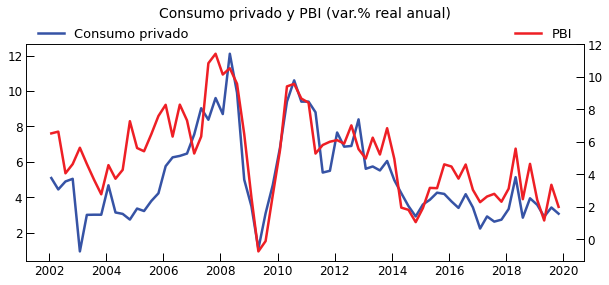

In [13]:
fig, ax1 = plt.subplots(figsize=(10, 4), linewidth = 2.5)
ax2 = ax1.twinx()

plt.text(0.5, 1.12, "Consumo privado y PBI (var.% real anual)", horizontalalignment='center', fontsize=14, transform = ax1.transAxes)

# Gráficas
ax1.plot(dta.index, dta["consumo"], label = "Consumo privado", color= "#3653A5", linewidth = 2.5)
ax2.plot(dta.index, dta["pbi"], label = "PBI", color= "#EE1F25", linewidth = 2.5)

# Posicionando las leyendas
ax1.legend(bbox_to_anchor=(0, 1.13), loc = 'upper left', fontsize=13, frameon=False)
ax2.legend(bbox_to_anchor=(1, 1.13), loc = 'upper right', fontsize=13, frameon=False)

# Editando los ticks
ax1.tick_params(direction='in', which='both', length=8, width=1, labelsize=12)
ax2.tick_params(direction='in', which='both', length=8, width=1, labelsize=12)


plt.savefig("./graphs/consumo-pbi.pdf", bbox_inches="tight", transparent=True)
plt.show()